# Environment

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Utility Functions

In [72]:
def print_model_history(history, metric, val=True):
  # summarize history for accuracy
  plt.plot(history.history[metric])
  if val:
    plt.plot(history.history['val_{}'.format(metric)])
    plt.legend(['train', 'test'], loc='upper left')
  else:
    plt.legend(['train'], loc='upper left')
  plt.title('model rmse error')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  if val:
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'test'], loc='upper left')
  else:
    plt.legend(['train'], loc='upper left')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  
  plt.show()

In [70]:
def build_model_and_train(dataset=None, X=None, y=None, epochs=100):

  model = keras.models.Sequential([
                                  keras.layers.Dense(10),
                                  keras.layers.Dense(10),
                                  keras.layers.Dense(1)
  ])

  m = keras.metrics.RootMeanSquaredError()

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=m)

  if dataset != None:
    history = model.fit(dataset, epochs=epochs, verbose=0, use_multiprocessing=True)
    print_model_history(history, metric='root_mean_squared_error', val=False)
    #return history 

  else:
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_split=0.1, use_multiprocessing=True)
    print_model_history(history, metric='root_mean_squared_error')

# Read Data from files


## Prepare files

In [2]:
file_path = '/content/sample_data/california_housing_train'
file_path_list = []

data = pd.read_csv(file_path + '.csv')

for i in range(10):
  file_path_temp = file_path + '_' +str(i) + '.csv'
  data.sample(1700).to_csv(file_path_temp, sep=',', index=False)
  file_path_list.append(file_path_temp)

## Read files

In [50]:
n_readers = 5 # how many files read at the same time
features = 8
repeat = True 
n_repeat = 10
cache = True
shuffle = True
shuffe_buffor = 10000
batch = True
batch_size = 32
prefetch = True

In [51]:
file_path_list_tf = tf.data.Dataset.list_files(file_path_list)

In [52]:
dataset = file_path_list_tf.interleave(
      lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
      cycle_length=n_readers, num_parallel_calls=tf.data.experimental.AUTOTUNE
  )

In [53]:
def string_to_vector(line):
  defs = [0.] * features + [tf.constant([], dtype=tf.float32)]
  fields = tf.io.decode_csv(line, record_defaults=defs)
  x = tf.stack(fields[:-1])
  y = tf.stack(fields[-1:])
  return x, y

In [54]:
dataset = dataset.map(string_to_vector,  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [55]:
if repeat:
  dataset = dataset.repeat(n_repeat)

if cache:
  dataset = dataset.cache()

if shuffle:
  dataset = dataset.shuffle(buffer_size=shuffe_buffor)

if batch:
  dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)

if prefetch:
  dataset = dataset.prefetch(1)

## Test on model

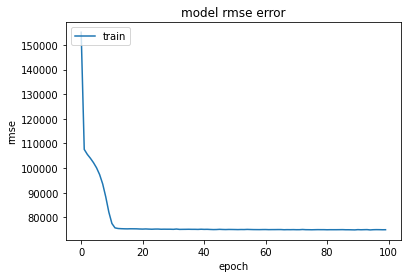

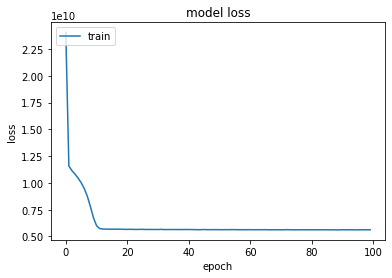

In [73]:
build_model_and_train(dataset, epochs=100)

# Read Data from TFDS

In [ ]:
!pip install tensorflow-datasets==3.2.1

In [124]:
import tensorflow_datasets as tfds
tfds.__version__

# Read Data from sklearn dataset


load_boston(*[, return_X_y]) - Load and return the boston house-prices dataset (regression).

load_iris(*[, return_X_y, as_frame]) - Load and return the iris dataset (classification).

load_diabetes(*[, return_X_y, as_frame]) - Load and return the diabetes dataset (regression).

load_digits(*[, n_class, return_X_y, as_frame]) - Load and return the digits dataset (classification).

load_linnerud(*[, return_X_y, as_frame]) - Load and return the physical excercise linnerud dataset.

load_wine(*[, return_X_y, as_frame]) - Load and return the wine dataset (classification).

load_breast_cancer(*[, return_X_y, as_frame]) - Load and return the breast cancer wisconsin dataset (classification).

In [36]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [37]:
data = datasets.load_iris(return_X_y=True)
X, y = data[1], data[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Read Data from pictures

# Read Data from CSV

## Read through numpy to memory 

Better for small sets and with only numerical features

In [111]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
test =  pd.read_csv('/content/sample_data/california_housing_test.csv')

X_train, y_train = train.drop(columns=['median_house_value']).to_numpy(), train['median_house_value'].to_numpy()
X_test, y_test = test.drop(columns=['median_house_value']).to_numpy(), test['median_house_value'].to_numpy()

In [113]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Read with data api

Better for big sets but data is kept in column format - harden to process

In [102]:
housing_csv_ds = tf.data.experimental.make_csv_dataset(
    '/content/sample_data/california_housing_train.csv',
    batch_size=25,
    label_name='median_house_value',
    num_epochs=1,
    ignore_errors=True,)

# Read data from Web

In [83]:
import os 
import tarfile
from six.moves import urllib

### Read TGZ Data from Web

In [84]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = '/content/sample_data/housing'
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

### Read CSV data from Web

In [86]:
housing_file_path = tf.keras.utils.get_file("housing.csv", DOWNLOAD_ROOT + 'datasets/housing/housing.csv')

1425408/1423529 [==============================] - 0s 0us/step


In [ ]:
housing_file_path = pd.read_csv(DOWNLOAD_ROOT + 'datasets/housing/housing.csv')

# Preprocessing

## Preprocessing standard datasets

### Standarization

In [120]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
X_train, y_train = train.drop(columns=['median_house_value']).to_numpy(), train['median_house_value'].to_numpy()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [129]:
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()

#### Method 1
Normalization calculated in 1st layer explicitdly



In [133]:
model = keras.models.Sequential([
                                 keras.layers.Lambda(lambda x: (x - mean)/(stds + 1)),
                                 keras.layers.Dense(10, activation='relu'),
                                 keras.layers.Dense(1, activation='relu')
])

#### Method 2
Build a class by inheriting from layer class

In [134]:
class Standarization(keras.layers.Layer):
  def adapt(self, data_sample):
    self.means_ = np.mean(data_sample, axis=0, keepdims=True)
    self.stds_ = np.std(data_sample, axis=0, keepdims=True)

  def call(self, inputs):
    return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [137]:
std_layer = Standarization() 
std_layer.adapt(X_train[:1000, :])

In [138]:
model = keras.models.Sequential([
                                 std_layer,
                                 keras.layers.Dense(10, activation='relu'),
                                 keras.layers.Dense(1, activation='relu')
])

#### Method3
Use TF **Transform**

In [ ]:
!pip install tensorflow_transform

In [141]:
import tensorflow_transform as tft

In [142]:
def preprocess(inputs):
  median_age = inputs['housing_median_age']
  standarized_age = tft.scale_to_z_score(median_age)

  return {'standarized_medium_age': standarized_age}

### Categorical variables encoding

In [159]:
#housing_file_path = tf.keras.utils.get_file("housing.csv", DOWNLOAD_ROOT + 'datasets/housing/housing.csv')

In [19]:
housing_file_path = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
housing_df = pd.read_csv(housing_file_path)
X_train_regular = housing_df.drop(columns=['median_house_value', 'ocean_proximity']).to_numpy()
X_train_categorical = housing_df['ocean_proximity'].to_numpy()
y_train = housing_df['median_house_value'].to_numpy()
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

means = np.mean(X_train_regular, axis=0, keepdims=True)
stds = np.std(X_train_regular, axis=0, keepdims=True)
eps = keras.backend.epsilon()

In [24]:
# Not using
# X_train, y_train =  housing_df['ocean_proximity'].to_numpy(), housing_df['median_house_value'].to_numpy()
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# for item in train_dataset.take(5):
#   print(item[0].numpy())

In [172]:
NUM_OOV_BUCKETS = 2
VOCAB = ['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']

indices = tf.range(len(VOCAB), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(VOCAB, indices)
table = tf.lookup.StaticVocabularyTable(table_init, NUM_OOV_BUCKETS)

#### One - hot Encoding

In [177]:
categories = tf.constant(['NEAR OCEAN', 'ISLAND', '<1H OCEAN', 'DESERT', 'MOUNTAINS'])
cat_indices = table.lookup(categories)
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>

#### Embedding Encoding

In [190]:
# sample implementaion
cat_sample = tf.constant(['NEAR OCEAN', 'ISLAND', '<1H OCEAN', 'DESERT', 'MOUNTAINS'])
cat_indices = table.lookup(cat_sample)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 4, 1, 7, 6])>

In [185]:
# Direct implementation
EMBEDDING_DIM = 3
embed_init = tf.random.uniform([len(VOCAB) + NUM_OOV_BUCKETS, EMBEDDING_DIM])
embed_matrix = tf.Variable(embed_init)
tf.nn.embedding_lookup(embed_matrix, cat_indices)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.47693503, 0.2651428 , 0.4181112 ],
       [0.69873154, 0.95583725, 0.33024645],
       [0.8526927 , 0.02772093, 0.7051302 ],
       [0.27623856, 0.61830723, 0.1851877 ],
       [0.42858732, 0.46090114, 0.8286818 ]], dtype=float32)>

In [188]:
# Implementaion as layer
EMBEDDING_DIM = 3
embedding = keras.layers.Embedding(input_dim=len(VOCAB) + NUM_OOV_BUCKETS, output_dim=EMBEDDING_DIM)
embedding(cat_indices)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 5.62295318e-05, -4.32376638e-02,  1.54911354e-03],
       [ 3.33996080e-02,  1.46732070e-02,  3.97942215e-03],
       [-4.35736552e-02, -1.65988430e-02,  4.20908444e-02],
       [ 2.73887850e-02, -2.16671582e-02, -1.03085525e-02],
       [ 2.54554488e-02,  1.36323683e-02,  2.85611860e-02]], dtype=float32)>

In [ ]:
# Book implementation
regular_input = keras.layers.Input(shape=[8])
categorical_input = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categorical_input)
cat_embed = keras.layers.Embedding(input_dim=len(VOCAB) + NUM_OOV_BUCKETS, output_dim=2)(cat_indices)
concat_inputs = keras.layers.concatenate([regular_input, cat_embed])
outputs = keras.layers.Dense(1)(concat_inputs)

model = keras.models.Model(inputs=[regular_input, categorical_input],
                           outputs=[outputs])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=keras.metrics.RootMeanSquaredError())

#history = model.fit((X_train_regular, X_train_categorical), y_train, batch_size=32, epochs=10, validation_split=0.1, use_multiprocessing=True)

In [22]:
# Full implementation

regular_input = keras.layers.Input(shape=[8])
standarized = keras.layers.Lambda(lambda x: (x - means)/(stds + eps))(regular_input)
categorical_input = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categorical_input)
cat_embed = keras.layers.Embedding(input_dim=len(VOCAB) + NUM_OOV_BUCKETS, output_dim=2)(cat_indices)
concat_inputs = keras.layers.concatenate([standarized, cat_embed])
Dense1 = keras.layers.Dense(10, 'relu')(concat_inputs)
outputs = keras.layers.Dense(1, 'relu')(Dense1)

model = keras.models.Model(inputs=[regular_input, categorical_input],
                           outputs=[outputs])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=keras.metrics.RootMeanSquaredError())

In [23]:
history = model.fit((X_train_regular, X_train_categorical), y_train, batch_size=32, epochs=10, validation_split=0.1, use_multiprocessing=True)

Epoch 1/10
581/581 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/10
581/581 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/10
581/581 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/10
581/581 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/10
581/581 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/10
581/581 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 7/10
581/581 [====================

## Preprocessing pictures

## Preprocessing Text

## TF Transform